- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


# 0. Import Module

In [1]:
import torch
from torch import nn, optim

from torch.utils.data import  TensorDataset, DataLoader
from torch.utils import data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import transforms
import os
import glob

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1006)
if device == "cuda":
  torch.cuda.manual_seed_all(1006)

print(device)

cuda


# 1. Dataset
- torchvision의 sat_data 사용


In [3]:
trans = transforms.Compose([transforms.ToTensor()])
sat_data = torchvision.datasets.EuroSAT(root="../data",transform=trans, download=True)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting ../data/eurosat/EuroSAT.zip to ../data/eurosat


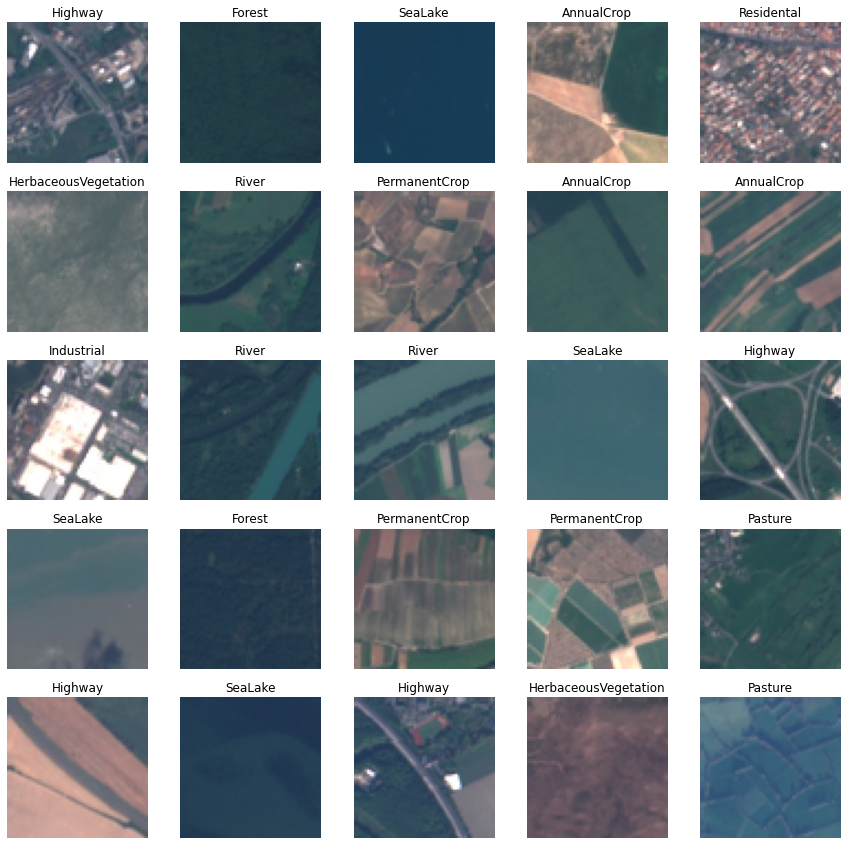

In [4]:
labels_map = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residental",
    8: "River",
    9: "SeaLake",
}

figure = plt.figure(figsize=(15, 15))

cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(sat_data), size=(1,)).item()

    img, label = sat_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

In [5]:
from tqdm import tqdm

## Save as array => pickle

In [6]:
ex_img, ex_label = sat_data[8000]
print(ex_img)
print(ex_label)

tensor([[[0.5961, 0.6118, 0.6275,  ..., 0.4824, 0.4784, 0.4627],
         [0.5843, 0.5961, 0.6157,  ..., 0.4902, 0.4745, 0.4549],
         [0.5608, 0.5725, 0.5765,  ..., 0.4980, 0.4824, 0.4588],
         ...,
         [0.5647, 0.5765, 0.6196,  ..., 0.5216, 0.5059, 0.5020],
         [0.5569, 0.5686, 0.6275,  ..., 0.5059, 0.5255, 0.5412],
         [0.6000, 0.6118, 0.6431,  ..., 0.4980, 0.5333, 0.5647]],

        [[0.5608, 0.5529, 0.5569,  ..., 0.4824, 0.4784, 0.4667],
         [0.5647, 0.5608, 0.5608,  ..., 0.4863, 0.4824, 0.4706],
         [0.5569, 0.5529, 0.5451,  ..., 0.4902, 0.4824, 0.4745],
         ...,
         [0.5294, 0.5255, 0.5451,  ..., 0.5059, 0.4824, 0.4745],
         [0.4980, 0.4941, 0.5451,  ..., 0.4824, 0.5020, 0.4980],
         [0.5255, 0.5176, 0.5451,  ..., 0.4745, 0.4980, 0.5176]],

        [[0.5333, 0.5333, 0.5412,  ..., 0.4745, 0.4784, 0.4863],
         [0.5490, 0.5412, 0.5490,  ..., 0.4784, 0.4784, 0.4745],
         [0.5412, 0.5373, 0.5333,  ..., 0.4941, 0.4824, 0.

In [7]:
len(sat_data)

27000

In [9]:
# sklearn의 train_test_split을 하려고 하는데 torchvision 이미지 데이터에 어떻게 적용해야하는지 잘 모르겠어서
# 불러온 sat_data를 따로 array로 저장

sat_input = []
sat_output = []

for i in tqdm(range(len(sat_data))):
  img, label = sat_data[i]

  # input과 output을 list에 저장
  sat_input.append(img.numpy())
  sat_output.append(label)

  # array
  sat_X = np.array(sat_input)
  sat_y = np.array(sat_output)

100%|██████████| 27000/27000 [1:13:13<00:00,  6.15it/s]


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# 저장하는데 오래걸려서 저장함!!
import pickle

In [12]:
# 저장
with open("/content/drive/MyDrive/Colab Notebooks/Euro_sat/sat_X.pickle","wb") as f:
    pickle.dump(sat_X, f)

with open("/content/drive/MyDrive/Colab Notebooks/Euro_sat/sat_y.pickle","wb") as f:
    pickle.dump(sat_y, f)

In [13]:
# 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/Euro_sat/sat_X.pickle', 'rb') as f:
    sat_X = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Euro_sat/sat_y.pickle', 'rb') as f:
    sat_y = pickle.load(f)

## Train Test Split

In [14]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(sat_X, sat_y, test_size = 0.3, random_state = 1006, shuffle = True)

X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)

X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [15]:
# Train data : 18900
print(X_train.shape)
print(y_train.shape)

torch.Size([18900, 3, 64, 64])
torch.Size([18900])


In [16]:
# Test data : 8100
print(X_test.shape)
print(y_test.shape)

torch.Size([8100, 3, 64, 64])
torch.Size([8100])


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

## Dataset & DataLoader

In [17]:
from torch.utils.data import Dataset

class SAT_data(Dataset):
  def __init__(self, data, targets):
    super().__init__()
    self.data = data
    self.targets = targets
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    return x, y

In [18]:
batch_size = 128

dataset_train = SAT_data(X_train, y_train)
dataset_test = SAT_data(X_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size) 
dataloader_test = DataLoader(dataset_test, batch_size=batch_size) 

In [19]:
dataset_train[100]

(tensor([[[0.1451, 0.1451, 0.1529,  ..., 0.1451, 0.1529, 0.1608],
          [0.1451, 0.1451, 0.1529,  ..., 0.1451, 0.1490, 0.1529],
          [0.1373, 0.1294, 0.1333,  ..., 0.1412, 0.1451, 0.1412],
          ...,
          [0.1608, 0.1608, 0.1529,  ..., 0.1255, 0.1176, 0.1216],
          [0.1608, 0.1608, 0.1490,  ..., 0.1412, 0.1373, 0.1333],
          [0.1216, 0.1216, 0.1255,  ..., 0.1333, 0.1373, 0.1333]],
 
         [[0.2314, 0.2353, 0.2431,  ..., 0.2627, 0.2588, 0.2549],
          [0.2353, 0.2353, 0.2431,  ..., 0.2627, 0.2588, 0.2588],
          [0.2275, 0.2314, 0.2353,  ..., 0.2588, 0.2627, 0.2588],
          ...,
          [0.2471, 0.2431, 0.2353,  ..., 0.2157, 0.2078, 0.2118],
          [0.2510, 0.2510, 0.2392,  ..., 0.2431, 0.2392, 0.2235],
          [0.2235, 0.2235, 0.2275,  ..., 0.2431, 0.2392, 0.2353]],
 
         [[0.3137, 0.3059, 0.2980,  ..., 0.3020, 0.3020, 0.3020],
          [0.3059, 0.2980, 0.3059,  ..., 0.3020, 0.3020, 0.3020],
          [0.2902, 0.2902, 0.2941,  ...,

In [30]:
dataset_test[100]

(tensor([[[0.3373, 0.3373, 0.3020,  ..., 0.2549, 0.2549, 0.2510],
          [0.3451, 0.3373, 0.3020,  ..., 0.2667, 0.2667, 0.2510],
          [0.3608, 0.3529, 0.3216,  ..., 0.2941, 0.2902, 0.2745],
          ...,
          [0.3647, 0.3725, 0.3765,  ..., 0.2863, 0.2902, 0.3255],
          [0.3137, 0.3176, 0.3216,  ..., 0.3176, 0.3216, 0.3294],
          [0.3333, 0.3333, 0.3137,  ..., 0.3098, 0.2941, 0.3137]],
 
         [[0.3725, 0.3765, 0.3451,  ..., 0.3333, 0.3333, 0.3098],
          [0.3686, 0.3725, 0.3451,  ..., 0.3294, 0.3294, 0.3059],
          [0.3843, 0.3882, 0.3608,  ..., 0.3373, 0.3333, 0.3216],
          ...,
          [0.3804, 0.3765, 0.3804,  ..., 0.3333, 0.3294, 0.3451],
          [0.3529, 0.3529, 0.3569,  ..., 0.3647, 0.3608, 0.3608],
          [0.3922, 0.3922, 0.3725,  ..., 0.3490, 0.3333, 0.3529]],
 
         [[0.3529, 0.3725, 0.3529,  ..., 0.3294, 0.3373, 0.3294],
          [0.3529, 0.3686, 0.3529,  ..., 0.3294, 0.3294, 0.3098],
          [0.3686, 0.3843, 0.3647,  ...,

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

# 2. Modeling
- input size : 3*64*64
- output size : 10
<br>

Model1 : Batchnormalization 사용 <br>

Model2 : Batchnormalization & Dropout 사용


In [25]:
class Model1(torch.nn.Module):

  def __init__(self):
    super(Model1, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3*64*64,512, bias=True), 
        nn.BatchNorm1d(512),
        nn.ReLU()
    )
  
    self.layer2 = nn.Sequential(
        nn.Linear(512,256, bias=True), 
        nn.BatchNorm1d(256),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(256,128, bias=True), 
        nn.BatchNorm1d(128),
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Linear(128, 64, bias=True), 
        nn.BatchNorm1d(64),
        nn.ReLU()
    )

    self.layer5 = nn.Sequential(
        nn.Linear(64, 10, bias=True), 
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    output = self.layer5(output)

    return output

In [26]:
class Model2(torch.nn.Module):
  def __init__(self):
    super(Model2, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3*64*64, 1024, bias=True),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )

    self.layer2 = nn.Sequential(
        nn.Linear(1024, 512, bias=True),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )

    self.layer3 = nn.Sequential(
        nn.Linear(512,256, bias=True),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )
        
    self.layer4 = nn.Sequential(
        nn.Linear(256,128, bias=True),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )

    self.layer5 = nn.Sequential(
        nn.Linear(128,64, bias=True),
        nn.BatchNorm1d(64),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )

    self.layer6 = nn.Sequential(
        nn.Linear(64,32, bias=True),
        nn.BatchNorm1d(32),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )

    self.layer7 = nn.Sequential(
        nn.Linear(32,16, bias=True),
        nn.BatchNorm1d(16),
        nn.Dropout(p=0.2),
        nn.ReLU()
        )

    self.layer8 = nn.Sequential(
        nn.Linear(16, 10),
        nn.Softmax(dim = 1)
        )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    output = self.layer5(output)
    output = self.layer6(output)
    output = self.layer7(output)
    output = self.layer8(output)

    return output

In [27]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)
        
        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

# 3. 사용할 함수 생성

In [32]:
# 각 시도에서 사용된 model & optimizer & lr과 그에 따른 loss 저장 ==> 나중에 시각화할 때 사용
train_history = []

# Optimizer 선정 함수
def get_optim(model, optim, lr):
  if optim == "sgd":
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
  elif optim == "adam":
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  elif optim == 'adagrad':
    optimizer = torch.optim.Adagrad(params=model.parameters(), lr=lr)
  elif optim == 'rmsprop':
    optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)
  else:
    print('잘못 입력 함')  

  return optimizer                                


# 나중에 모델 결과 값을 for문으로 한번에 받고 싶어서 train&test에 사용할 train_test 함수 생성
def train_test(model=None, epoch=100, lr=0.01, optim=None, Train_data=None, Test_data = None):
  losses_train = []
  
  optimizer = get_optim(model, optim, lr) # get_optim 사용해서 optimizer 선정
  loss_fn = nn.CrossEntropyLoss().to(device)

  model.train() 

  ##### Train #####
  print("===== Start Train =====")
  for epoch in range(epoch):
    # 기존 코드와 동일
    for X_train, y_train in Train_data:
      optimizer.zero_grad()
      y_train_pred = model(X_train)
      cost_train = loss_fn(y_train_pred, y_train)
      cost_train.backward()
      optimizer.step()

    losses_train.append(cost_train.item())  #loss를 list에 저장해서 나중에 시각화

    if epoch % 10 == 0:
      print(f'{epoch}번째 epoch의 loss : {round(cost_train.item(),8)}')

  # 학습 결과를 history(딕셔너리에 저장)
  history = {}
  history['model'] = model
  history['optimizer'] = optim
  history['lr'] = lr
  history['loss'] = losses_train

  train_history.append(history)

  ##### Test #####
  print("===== Start Test =====")
  loss = 0
  model.eval()
  with torch.no_grad():
    for X_test, y_test in Test_data:
      y_test_pred = model(X_test)

      ## Test Loss
      cost_test = loss_fn(y_test_pred, y_test)
      loss += cost_test.item()  # loss의 누적 

      ## Test Accuracy :: accuracy_score  => array 형태로 저장 
      y_test_pred = y_test_pred.cpu().detach().numpy()
      y_test = y_test.detach().cpu().numpy()

      predicted = np.argmax(y_test_pred, axis =1)
      accuracy = (accuracy_score(predicted, y_test))

  loss /= len(Test_data) # loss 평균

  print(f'Test loss : {round(loss,8)}\n  Accuracy : {round(accuracy,5)}')

# 4. Train & Test model

In [33]:
optim = ['sgd','adam','adagrad','rmsprop']
lr = [0.05, 0.01, 0.005]
model = [Model1, Model2]  # model class를 list에 저장

for model_class in model:
  for o in optim:
    for l in lr:
      m = model_class().to(device)  #model 생성 후
      m.apply(init_weights)   #xavier 초기화

      print(f'Train with model : {model_class}, optimizer : {o}, learning rate : {l} ')

      train_test(m, 100, l, o, dataloader_train, dataloader_test)

Train with model : <class '__main__.Model1'>, optimizer : sgd, learning rate : 0.05 
===== Start Train =====
0번째 epoch의 loss : 2.01196742
10번째 epoch의 loss : 1.602512
20번째 epoch의 loss : 1.56003547
30번째 epoch의 loss : 1.49203086
40번째 epoch의 loss : 1.47684622
50번째 epoch의 loss : 1.47634947
60번째 epoch의 loss : 1.47450089
70번째 epoch의 loss : 1.47493458
80번째 epoch의 loss : 1.47383225
90번째 epoch의 loss : 1.47476852
===== Start Test =====
Test loss : 1.80147777
  Accuracy : 0.66667
Train with model : <class '__main__.Model1'>, optimizer : sgd, learning rate : 0.01 
===== Start Train =====
0번째 epoch의 loss : 2.08421206
10번째 epoch의 loss : 1.7735436
20번째 epoch의 loss : 1.66594458
30번째 epoch의 loss : 1.58750081
40번째 epoch의 loss : 1.54688704
50번째 epoch의 loss : 1.52660728
60번째 epoch의 loss : 1.51437891
70번째 epoch의 loss : 1.49969566
80번째 epoch의 loss : 1.48863316
90번째 epoch의 loss : 1.48782647
===== Start Test =====
Test loss : 1.91830482
  Accuracy : 0.58333
Train with model : <class '__main__.Model1'>, optimiz

In [34]:
len(train_history)

24

# 5. Plot history

In [39]:
def plot_all(train_history):
  fig = plt.figure(figsize=(20,40))
  l = int(len(train_history))
  for i in range(1,len(train_history)+1):
    history = train_history[i-1]

    model = history['model']
    optim = history['optimizer']
    lr = history['lr']
    loss = history['loss']

    ax = fig.add_subplot(8, 3, i)
    ax.plot(loss, color="blue", label="train loss")
    if i <= 8:
      ax.set_title(f'Model1, {optim}, {lr}')
    else:
      ax.set_title(f'Model2, {optim}, {lr}')
    ax.legend()
  
  fig.show()
  fig.savefig('/content/drive/MyDrive/Colab Notebooks/3차과제_history.png')

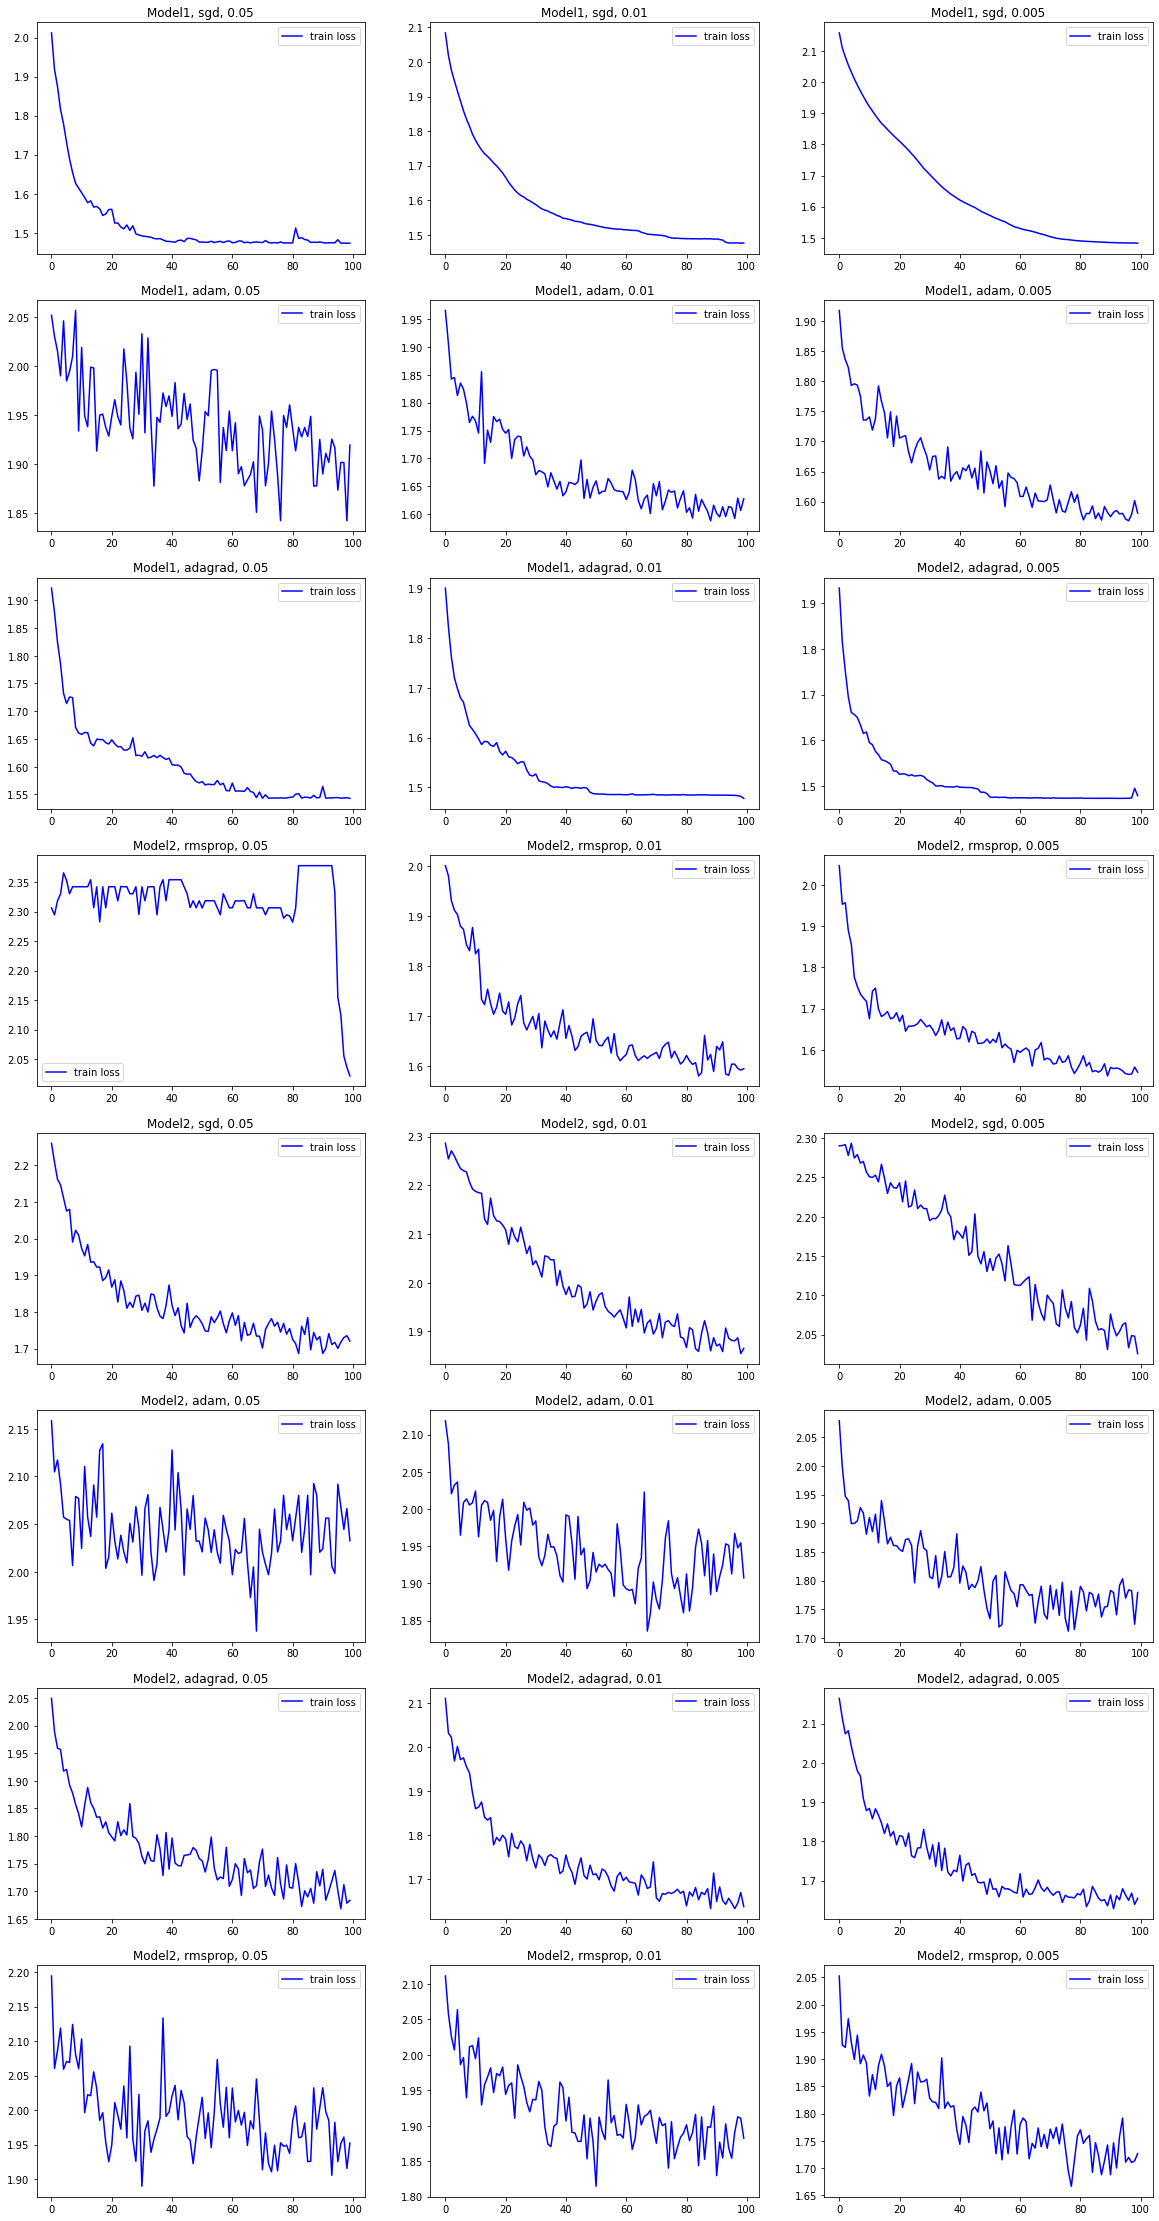

In [40]:
plot_all(train_history)

# 결론
Model2, optimizer : sgd, learning rate : 0.05 <br>
Model2, optimizer : adagrad, learning rate : 0.01 <br>
각각 Test Accuracy 기준으로 0.75로 가장 좋은 성능을 보였다.


# 아쉬운 점
1. 사용한 데이터셋 형태에 대한 이해가 조금 부족했어서 직접 데이터를 list에 저장한 후 진행했는데 맞는 방법인지를 잘 모르겠었다. <br>
2. 다양하게 모델을 구성해서 시도해보고 싶었는데 그러지 못했었다. <br>
3. 생각보다 시간이 오래 걸렸어서 더 다양한 경우에 대한 시도를 못했다. EX)다양한 model, lr, optimizer, epoch
